In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

# Preparando los datos
Se comienza por cargar el dataset y hecharle una primera mirada.
Esto muestra las clases y las caracteristicas (que todavia falta averiguar que significan).
El dataset no tiene valores faltantes, por lo que se puede ocupar sin un trabajo previo de preparacion.

In [2]:
df = pd.read_csv("SDSS-DR14.csv", sep=',', header=0)
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [4]:
df.isnull().sum()

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

In [5]:
df.groupby("class").count()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
class,,,,,,,,,,,,,,,,,
GALAXY,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998,4998
QSO,850,850,850,850,850,850,850,850,850,850,850,850,850,850,850,850,850
STAR,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152,4152


El dataset esta claramente desbalanceado, ya que hay muy pocas observaciones de quasares.
Hay que tener cuidado al hacer oversampling o undersampling ya que introduce "bias" (especialmente en los arboles). Inicialmente se balancearon los datos antes de divirlos en train/test y los algoritmos basados en arboles tuvieron resultados cercanos al 100%. Sin embargo al hacer over/under sampling despues de split bajaron casi todos los valores, y fueron similares a no usar niguno de los dos. Pero en esos dos casos los dataset de entrenamiento deberian ser casi iguales, por lo que el cambio en los resultados se debe al "bias".

Tambien fue necesario escalar los datos para la regresion logistica.

In [3]:
# after split {'GALAXY': 3545, 'QSO': 603, 'STAR': 2852}
samples = {"GALAXY":3545, "QSO":2603, "STAR":2852 }

oversampler = RandomOverSampler(sampling_strategy=samples)
undersampler = RandomUnderSampler(sampling_strategy=samples)


X = df.drop(["class"],axis=1)
Y = df.iloc[:,13]

mask = [3, 4, 5, 6, 7, 13]
X = X.iloc[:, mask]
display(X.columns)

Xo_train, X_test, Yo_train, Y_test = train_test_split(X, Y, test_size = .3, random_state=25)

X_train, Y_train = oversampler.fit_resample(Xo_train, Yo_train)
#X_train, Y_train = undersampler.fit_resample(Xo_train, Yo_train)


scaler = preprocessing.StandardScaler().fit(X)
Xos_train = scaler.transform(Xo_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

Index(['u', 'g', 'r', 'i', 'z', 'redshift'], dtype='object')

En cuanto a las caracteristicas que utilizar en los modelos hubo problemas para encontrar su significado y como no hay ninguna que diga la respuesta aparte de "class", inicialmente simplemente se utilizaron todas las caracteristicas del dataset y despues se eliminaron las con menos influencia.
Despues de ver el significado de las caracteristicas se aprecia que se elminaron los id y las relacionadas al telescopio y a la run, que obviamente no tienen ningun efecto en la clase del objeto.
Llama la atencion que la fecha (mjd) afecte la clasificacion de las clases (principalmente quasar)

# Logistic Regression

In [5]:
print("Dataset original:")
LogReg = LogisticRegression(multi_class='multinomial', max_iter=1000, solver="newton-cg")
LogReg.fit(Xos_train, Yo_train)
Yo_pred = LogReg.predict(Xs_test)
confusion_matrix = metrics.confusion_matrix(Y_test, Yo_pred)
display(confusion_matrix)
print(classification_report(Y_test, Yo_pred))

print("Over/Under sampling:")
LogReg = LogisticRegression(multi_class='multinomial', max_iter=1000, solver="newton-cg")
LogReg.fit(Xs_train, Y_train)
Y_pred = LogReg.predict(Xs_test)
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
display(confusion_matrix)
print(classification_report(Y_test, Y_pred))

display(LogReg.coef_)

Dataset original:


array([[1400,    4,   49],
       [  20,  227,    0],
       [  14,    2, 1284]], dtype=int64)

              precision    recall  f1-score   support

      GALAXY       0.98      0.96      0.97      1453
         QSO       0.97      0.92      0.95       247
        STAR       0.96      0.99      0.98      1300

    accuracy                           0.97      3000
   macro avg       0.97      0.96      0.96      3000
weighted avg       0.97      0.97      0.97      3000

Over/Under sampling:


array([[1397,    7,   49],
       [  11,  236,    0],
       [  12,    5, 1283]], dtype=int64)

              precision    recall  f1-score   support

      GALAXY       0.98      0.96      0.97      1453
         QSO       0.95      0.96      0.95       247
        STAR       0.96      0.99      0.97      1300

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



array([[  1.04639476,  -1.45714554,   1.35822011,  -0.17249594,
         -0.96896683,   7.9368439 ],
       [ -3.27783766,   5.10887184,   1.22450164,  -0.76930115,
         -2.59069225,  11.68673629],
       [  2.2314429 ,  -3.65172631,  -2.58272175,   0.94179709,
          3.55965908, -19.62358019]])

La regresion logistica es la que en general peor predice las clases, pero es el modelo que mejor reconoce los quasares.
En cuanto al oversampling, este no tiene mucho efecto en el modelo, pero dependiendo del metodo utilizado y dela cantidad de samples de cada clase puede causar un empeoramiento en las predicciones.

Tambien se debe tener en cuenta que newton-cg es el que produce mejores resultados generales, pero otros metodos producen un mejor reconocimiento de quasares a cambio de un peor reconocimiento de estrellas y galaxias

Se puede apreciar que el redshift es el componente mas importante para la clasificacion.

# Decision Tree

In [65]:
dtree = tree.DecisionTreeClassifier()
dtree.fit(X_train, Y_train)

tree_pred = dtree.predict(X_test)
confusion_matrix = metrics.confusion_matrix(Y_test, tree_pred)
display(confusion_matrix)
print(classification_report(Y_test, tree_pred))

array([[1445,    6,    2],
       [  27,  220,    0],
       [   8,    2, 1290]], dtype=int64)

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99      1453
         QSO       0.96      0.89      0.93       247
        STAR       1.00      0.99      1.00      1300

    accuracy                           0.98      3000
   macro avg       0.98      0.96      0.97      3000
weighted avg       0.98      0.98      0.98      3000



Despues del error de hacer oversampling antes de split en los datos, queda bastante claro lo "biased" que pueden ser los arboles y el random forest tambien, ya que la tenia una prediccion casi del 100%, lo que no sucedio con la regresion logistica.

Al igual que en la regresion logistica se aprecia lo importante que es el redshift, que es usado al principio para separar en gran medida las 3 clases. De hecho al hacer la prueba si solo se considera el redshift como unica caracteristica el cambio en la deteccion de galaxias y estrellas es insignificante, solo empeora un poco la deteccion de quasares.
Ocurre algo similar en la regersion logistica y random forest, solo que en ese caso la deteccion de quasares emperora en gran medida, especialmente en la regresion.

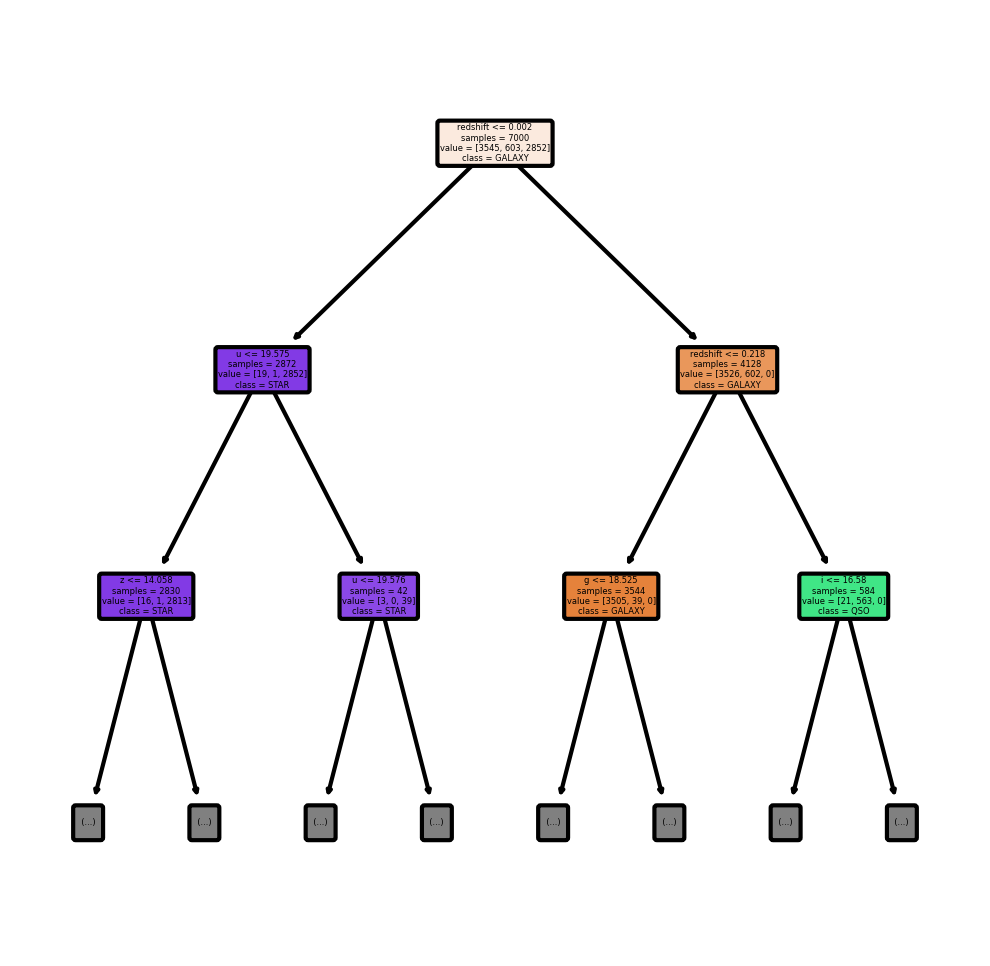

In [58]:
features=list(X.columns)
classes=["GALAXY", "QSO", "STAR"]

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(dtree, feature_names=features, class_names=classes, filled=True, 
                     rounded=True, impurity=False, max_depth=2);
fig.savefig('modelo.png')

# Random Forest

In [79]:
rforest = RandomForestClassifier(n_estimators=15)
rforest.fit(X_train, Y_train)

#Predicciones
forest_pred = rforest.predict(X_test)
#Evaluación del rendimiento del clasificador
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, forest_pred)
print(confusion_matrix)
#Print de la matriz de confusión
from sklearn.metrics import classification_report
print(classification_report(Y_test, forest_pred))

[[1444    6    3]
 [  21  226    0]
 [   4    0 1296]]
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99      1453
         QSO       0.97      0.91      0.94       247
        STAR       1.00      1.00      1.00      1300

    accuracy                           0.99      3000
   macro avg       0.98      0.97      0.98      3000
weighted avg       0.99      0.99      0.99      3000



El random forest tiene un comportamiento similar a los arboles de decision, pero produce mejores resultados. Esto se nota claramente en los quasares. Por una parte el arbol de decision es capaz de reconocer estrellas solo con el redshift pero tiene problemas para distingir quasares usando el resto de caracteristicas. En cambio el random forest utiliza mejor esas caracterisaticas para distinguir los quasares, y reconoce las estrellas con la misma facilidad.


# Conclusion
Al comparar los modelos lo primero que se aprecia es que ante la posibilidad de usar random forest no vale la pena usar simplemente un arbol de decision, ya que uno es simplemente una implementacion mejorada del otro. Aunque en algunos casos puede no ser viable el entrenamiento de tantos modelos, lo que claramente es una ventaja de utilizar un solo arbol en ciertos casos.

Al comparar el random forest con la regresion logistica se aprecia que el random forest es mejor en general. Tiene mejor precision y recall de galaxias y estrellas y mejor precision en quasares. Sin embargo la regresion logistica tiene un recall mejor recall de quasares, siendo la diferencia mejora mayor que el empeoramineto de la deteccion de cualquiera de las otras clases.Por lo tanto que modelo utilizar depende del objetivo para el que se quieran utilizar, y si es posible seria recomendable usar ambos.